# Import Library and Dataset

In [108]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

import tensorflow as tf

import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath('..'))

from rnn import rnn_unidirectional, rnn_bidirectional
from utils import embedding, dense, softmax

In [109]:
train_df = pd.read_csv("../../data/train.csv")
valid_df = pd.read_csv("../../data/valid.csv")
test_df = pd.read_csv("../../data/test.csv")

train_df.head(), valid_df.head(), test_df.head()

(    id                                               text     label
 0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
 1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
 2  436               Ibu pernah bekerja di grab indonesia   neutral
 3  394  Paling suka banget makan siang di sini ayam sa...  positive
 4  592                    Pelayanan bus DAMRI sangat baik  positive,
     id                                               text     label
 0  237  Jika ada pertanyaan lebih lanjut yang ingin ka...   neutral
 1  101  Rasanya sih kok harga kaki lima dan rasanya ya...  negative
 2  556  Minimal cek pesan saya, ada problem yang rumit...   neutral
 3  474  Dulu restoran ini merupakan favorit saya karen...  negative
 4   42  Merupakan resto vintage dengan harga yang cuku...  positive,
     id                                               text     label
 0  411  Dekat dengan hotel saya menginap, hanya ditemp...  positive
 1  729                 Iya bena

# Preprocessing

In [110]:

label_encoder = LabelEncoder()
train_df["label_encoded"] = label_encoder.fit_transform(train_df["label"])
valid_df["label_encoded"] = label_encoder.transform(valid_df["label"])
test_df["label_encoded"] = label_encoder.transform(test_df["label"])

train_texts = train_df["text"].astype(str).tolist()
train_labels = train_df["label_encoded"].tolist()
valid_texts = valid_df["text"].astype(str).tolist()
valid_labels = valid_df["label_encoded"].tolist()
test_texts = test_df["text"].astype(str).tolist()
test_labels = test_df["label_encoded"].tolist()

label_encoder.classes_, train_df[["label", "label_encoded"]].drop_duplicates()

(array(['negative', 'neutral', 'positive'], dtype=object),
       label  label_encoded
 0   neutral              1
 1  positive              2
 7  negative              0)

In [111]:
vocab_size = 10000
sequence_length = 100

vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
vectorizer.adapt(train_texts)

X_train = vectorizer(tf.convert_to_tensor(train_texts))
X_valid = vectorizer(tf.convert_to_tensor(valid_texts))
y_train = tf.convert_to_tensor(train_labels)
y_valid = tf.convert_to_tensor(valid_labels)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(TensorShape([500, 100]),
 TensorShape([500]),
 TensorShape([100, 100]),
 TensorShape([100]))

# Training Variation

In [112]:
def build_model(num_layers=1, rnn_units=64, bidirectional=True):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128))

    for i in range(num_layers):
        rnn_layer = tf.keras.layers.SimpleRNN(rnn_units, return_sequences=(i < num_layers - 1))
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(rnn_layer))
        else:
            model.add(rnn_layer)

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [113]:
def train_and_evaluate(num_layers=1, rnn_units=64, bidirectional=True):
    print(f"Training model | Layers: {num_layers}, Units: {rnn_units}, Bidirectional: {bidirectional}")
    model = build_model(num_layers=num_layers, rnn_units=rnn_units, bidirectional=bidirectional)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=10,
        batch_size=32,
        verbose=0
    )
    
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    f1 = f1_score(y_valid, y_pred, average="macro")
    
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"Loss Curve | Layers: {num_layers}, Units: {rnn_units}, Bi: {bidirectional}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Macro F1 Score: {f1:.4f}\n")
    
    return model, history, f1


## Number of RNN Layers

Training model | Layers: 1, Units: 64, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


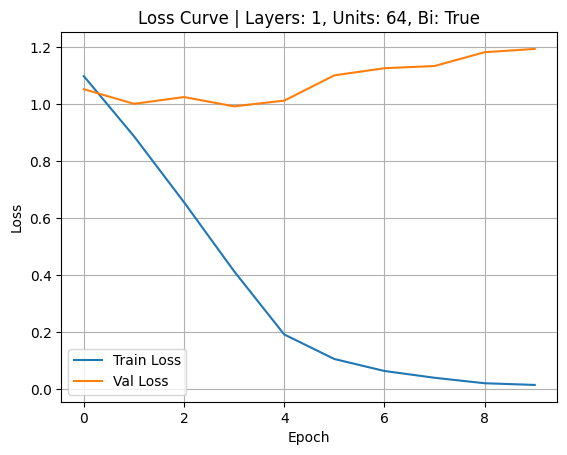

Macro F1 Score: 0.5157

Training model | Layers: 2, Units: 64, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


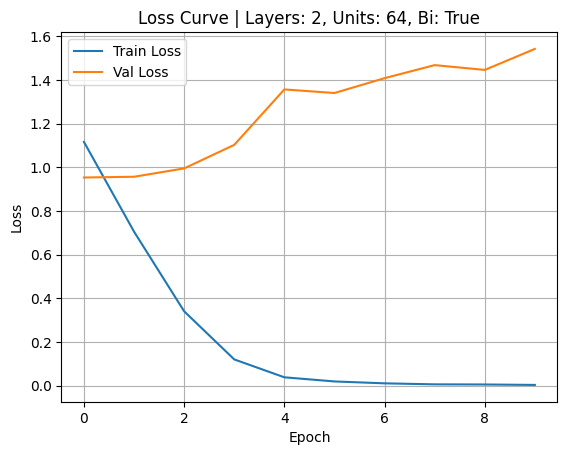

Macro F1 Score: 0.5433

Training model | Layers: 3, Units: 64, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


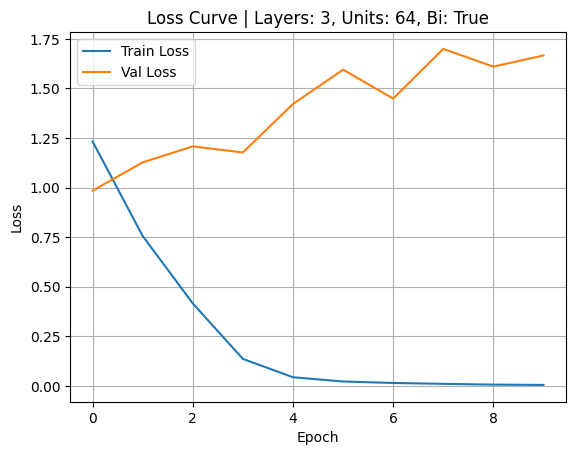

Macro F1 Score: 0.4334



In [114]:
layer_nums = [1, 2, 3]

for n in layer_nums:
    train_and_evaluate(num_layers=n)

## Number of Cells in RNN Layer

Training model | Layers: 1, Units: 32, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


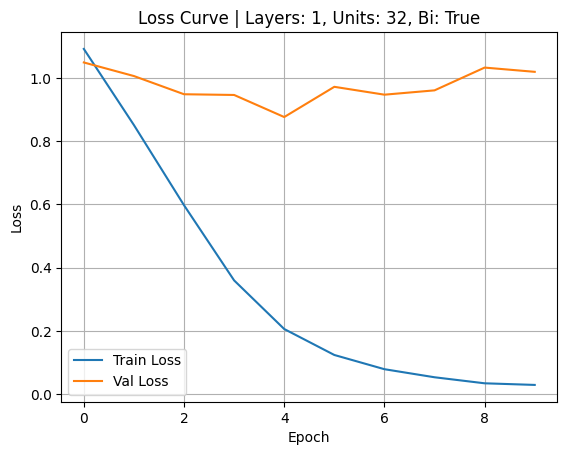

Macro F1 Score: 0.5887

Training model | Layers: 1, Units: 64, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


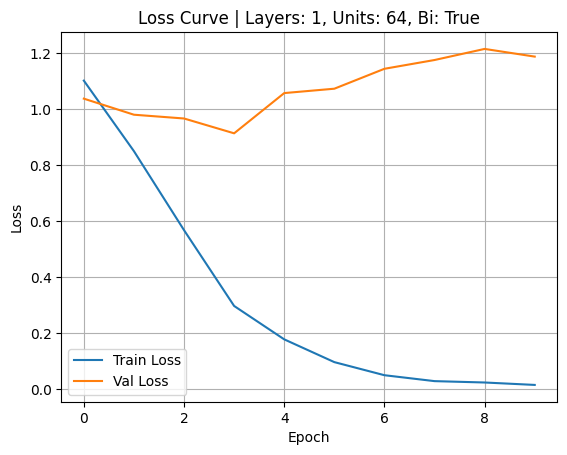

Macro F1 Score: 0.5291

Training model | Layers: 1, Units: 128, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


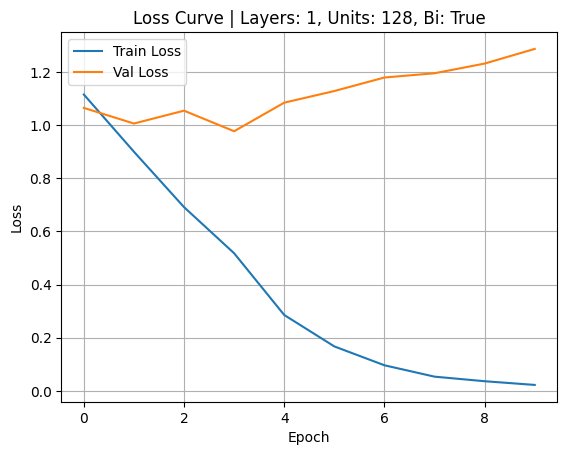

Macro F1 Score: 0.4085



In [115]:
cell_nums = [32, 64, 128]

for n in cell_nums:
    train_and_evaluate(rnn_units=n)

## Type of RNN Layer

Training model | Layers: 1, Units: 64, Bidirectional: True
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


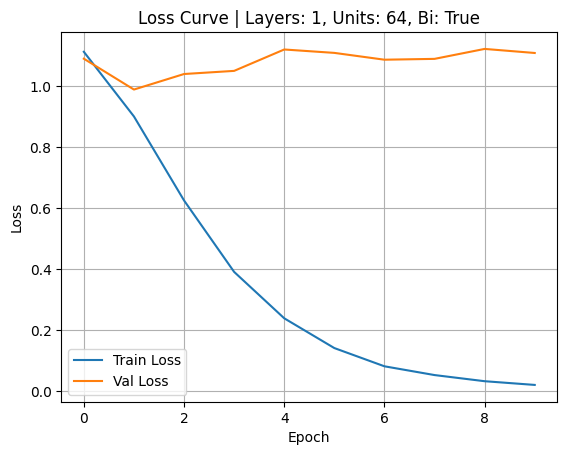

Macro F1 Score: 0.5690

Training model | Layers: 1, Units: 64, Bidirectional: False
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


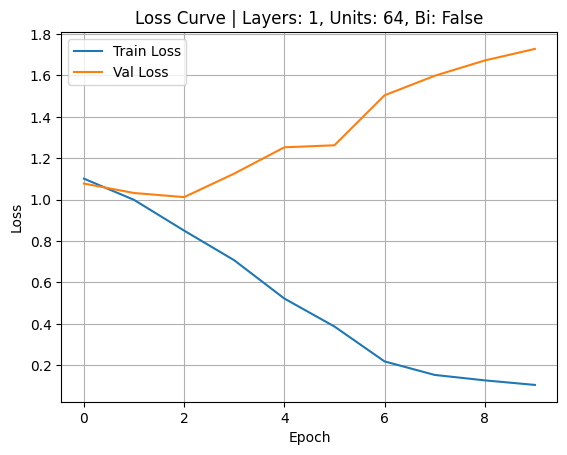

Macro F1 Score: 0.4672



(<Sequential name=sequential_76, built=True>,
 0.46721020914569306)

In [116]:
train_and_evaluate(bidirectional=True)
train_and_evaluate(bidirectional=False)

# Save Weights

In [117]:
final_model = build_model(num_layers=1, rnn_units=64, bidirectional=True)
final_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=32)
final_model.save_weights("rnn_model.weights.h5")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3705 - loss: 1.1008 - val_accuracy: 0.5100 - val_loss: 1.0402
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6631 - loss: 0.8496 - val_accuracy: 0.4700 - val_loss: 1.0095
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8189 - loss: 0.6258 - val_accuracy: 0.5300 - val_loss: 0.9693
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8974 - loss: 0.3866 - val_accuracy: 0.5200 - val_loss: 0.9532
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9608 - loss: 0.2177 - val_accuracy: 0.4600 - val_loss: 1.1204
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9830 - loss: 0.1151 - val_accuracy: 0.4400 - val_loss: 1.2099
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9977 - loss: 0.0682 - val_accuracy: 0.5200 - val_loss: 1.1726
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9975 - loss: 0.0445 - val_accuracy: 0.5100 - v

# Inference From Scratch
## Load Weights

In [118]:
model = build_model(num_layers=1, rnn_units=64, bidirectional=True)
_ = model(tf.zeros((1, sequence_length), dtype=tf.int32))
model.load_weights("rnn_model.weights.h5")

c:\Users\HP PAVILION X360\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [119]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, weights: {[w.shape for w in layer.get_weights()]}")

Layer 0: embedding_78, weights: [(10000, 128)]
Layer 1: bidirectional_94, weights: [(128, 64), (64, 64), (64,), (128, 64), (64, 64), (64,)]
Layer 2: dropout_78, weights: []
Layer 3: dense_78, weights: [(128, 3), (3,)]


## Forward Propagation

In [120]:

def forward(X, bidirectional=True):
    embedding_matrix = model.layers[0].get_weights()[0]
    x_embed = embedding(X, embedding_matrix)

    if bidirectional:
        W_x_f, W_h_f, b_f = model.layers[1].forward_layer.get_weights()
        W_x_b, W_h_b, b_b = model.layers[1].backward_layer.get_weights()

        x_rnn = rnn_bidirectional(x_embed, W_x_f, W_h_f, b_f, W_x_b, W_h_b, b_b)
    else:
        W_x, W_h, b = model.layers[1].get_weights()
        x_rnn = rnn_unidirectional(x_embed, W_x, W_h, b)

    W_dense, b_dense = model.layers[3].get_weights()
    logits = dense(x_rnn, W_dense, b_dense)

    probs = softmax(logits)
    preds = np.argmax(probs, axis=1)
    return preds


In [121]:
X_test = vectorizer(test_texts).numpy()
y_test = test_labels

keras_preds = model.predict(X_test)
keras_preds = np.argmax(keras_preds, axis=1)

manual_preds = forward(X_test, bidirectional=True)

print("Keras Macro F1:", f1_score(y_test, keras_preds, average='macro'))
print("Manual Macro F1:", f1_score(y_test, manual_preds, average='macro'))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Keras Macro F1: 0.49474738821065656
Manual Macro F1: 0.49474738821065656
